In [1]:
import pandas as pd
import numpy as np
import scipy 
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree, fcluster, cophenet
from scipy.spatial.distance import pdist

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_rows = 4000

In [2]:
analysis = '/work/projects/ecosystem_biology/archaea/coevolution/analysis'

functions_archaea = pd.read_csv(analysis+'/intermediate_results/archaea_kegg_unique_gut_functions_annotation.csv',
           sep='\t')
functions_archaea['cluster'] = 'a_' + functions_archaea['cluster'].astype(str)
functions_archaea.rename(columns={'cluster':'ids'}, inplace=True)
functions_archaea = functions_archaea[['protein', 'ids', 'id', 'description']]

functions_bac = pd.read_csv(analysis+'/intermediate_results/bacteria_kegg_gut_functions_annotation.csv',
           sep='\t')
functions_bac.rename(columns={'cluster':'ids'}, inplace=True)

In [3]:
functions_arch_and_bac = pd.concat([functions_archaea, functions_bac])

In [4]:
matrix = pd.read_csv('/work/projects/coevolution/phylogeny/smash/bac_VS_arch_common_kegg_ids_ALL/analysis/out.csv')
matrix.head()

a_100893.fasta  a_102072.fasta  a_103470.fasta  a_104986.fasta  \
0             1.0             0.0             0.0             0.0   
1             0.0             1.0             0.0             0.0   
2             0.0             0.0             1.0             0.0   
3             0.0             0.0             0.0             1.0   
4             0.0             0.0             0.0             0.0   

   a_107930.fasta  a_108584.fasta  a_10982.fasta  a_115303.fasta  \
0             0.0             0.0            0.0             0.0   
1             0.0             0.0            0.0             0.0   
2             0.0             0.0            0.0             0.0   
3             0.0             0.0            0.0             0.0   
4             1.0             0.0            0.0             0.0   

   a_116925.fasta  a_121399.fasta  ...  b_9941106.fasta  b_9942533.fasta  \
0             0.0             0.0  ...              0.0              0.0   
1             0.0             0.0  ...              0.0              0.0   
2             0.0             0.0  ...              0.0              0.0   
3             0.0             0.0  ...              0.0              0.0   
4             0.0             0.0  ...              0.0              0.0   

   b_9949824.fasta  b_9950112.fasta  b_9955350.fasta  b_9956428.fasta  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   
3              0.0              0.0              0.0              0.0   
4              0.0              0.0              0.0              0.0   

   b_9960132.fasta  b_997696.fasta  b_997808.fasta  b_9981406.fasta  
0              0.0             0.0             0.0              0.0  
1              0.0             0.0             0.0              0.0  
2              0.0             0.0             0.0              0.0  
3              0.0             0.0             0.0              0.0  
4              0.0             0.0             0.0              0.0  

[5 rows x 2633 columns]

In [5]:
labels = matrix.columns
# Perform clustering, you can choose the method
# in this case, we use 'ward'
Z = linkage(matrix)

In [6]:
max_d = round(0.3*max(Z[:,2]), 2)
max_d

0.52

Text(0.5, 1.0, 'Hierarchical Clustering Dendrogram, threshold = 0.52')

Text(0, 0.5, 'sample id')

Text(0.5, 0, 'distance')

([<matplotlib.axis.XTick at 0x2aac276f2940>,
 <a list of 33 Text major ticklabel objects>)

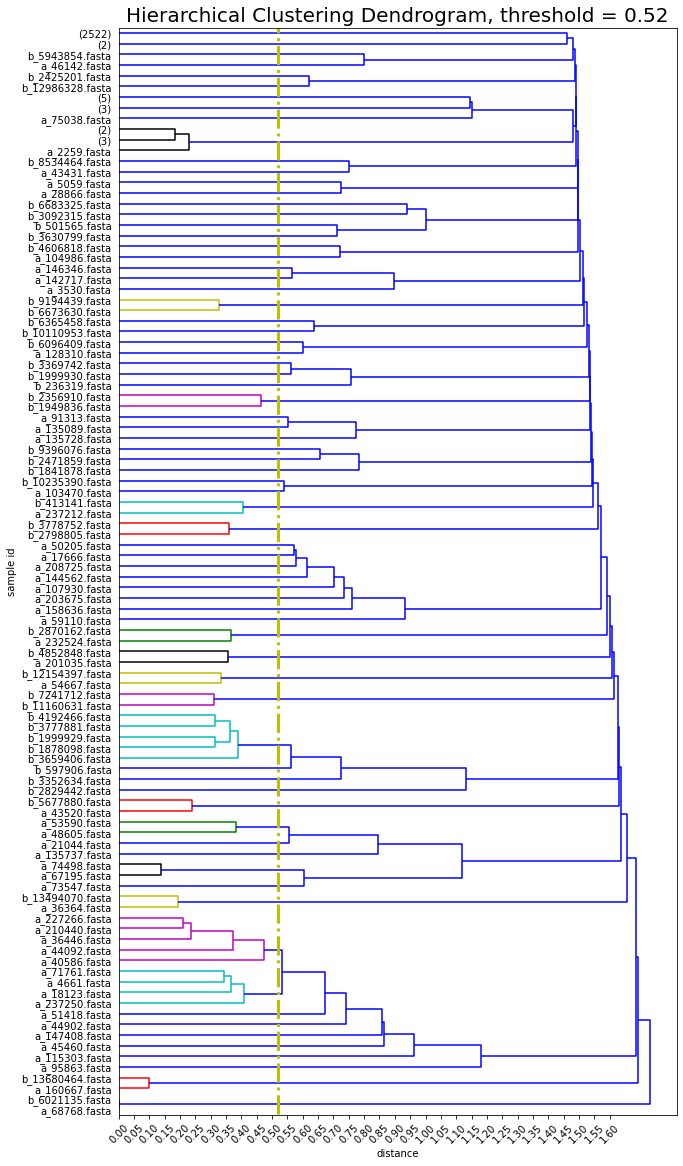

In [7]:
# plot the full diagram

# fig = plt.figure(figsize=(10, 100))
# dn = dendrogram(Z, 
#                 orientation='right', 
#                 labels=labels, color_threshold=max_d)
# plt.title('Hierarchical Clustering Dendrogram, threshold = '+str(max_d), fontsize=20)
# plt.ylabel('sample id', fontsize=10)
# plt.xlabel('distance', fontsize=10)
# plt.xticks(np.arange(0, 1.65, step=0.05), rotation=45)
# plt.tick_params(axis='both', which='major', labelsize=10)
# plt.plot([max_d,max_d], [max_d, 100000], 'y-.', lw=3) 
# plt.savefig('/work/projects/ecosystem_biology/archaea/coevolution/analysis/intermediate_results/pics/\
# dendrogram_common_ALL_'+str(max_d)+'.png', 
#             format='png', dpi=150)
# plt.show()


# plot the truncated diagram

fig = plt.figure(figsize=(10, 20))
dn = dendrogram(Z, 
                orientation='right', 
                labels=labels, color_threshold=max_d, truncate_mode='level')
plt.title('Hierarchical Clustering Dendrogram, threshold = '+str(max_d), fontsize=20)
plt.ylabel('sample id', fontsize=10)
plt.xlabel('distance', fontsize=10)
plt.xticks(np.arange(0, 1.65, step=0.05), rotation=45)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.plot([max_d,max_d], [max_d, 100000], 'y-.', lw=3) 
# plt.savefig('/work/projects/ecosystem_biology/archaea/coevolution/analysis/intermediate_results/pics/\
# truncated_dendrogram_common_ALL_'+str(max_d)+'.png', 
#             format='png', dpi=150)
# plt.show()

In [8]:
clusters = fcluster(Z, max_d, criterion='distance')

clusters = pd.DataFrame(clusters, labels)
clusters.columns = ['cluster']
clusters.reset_index(level=0, inplace=True)
clusters.rename(columns={'index' : 'ids'}, inplace=True)

clusters.ids = clusters.ids.str.rstrip('.fasta')

clusters_count = clusters.groupby('cluster', as_index=False)\
.agg({'ids':'count'})\
.rename(columns={'ids':'count'})\
.sort_values('count', ascending=False)

which smash clusters contain which protein clusters:

In [9]:
candidates = clusters_count.merge(clusters, on='cluster')

In [10]:
# count archaeal PFs
tmp_a = clusters_count.merge(clusters, on='cluster').groupby('cluster', as_index=False)\
.agg({'ids':lambda x: x[x.str.startswith('a_')].count()})\
.rename(columns={'ids':'count_a'})

# count bacterial PFs
tmp_b = clusters_count.merge(clusters, on='cluster').groupby('cluster', as_index=False)\
.agg({'ids':lambda x: x[x.str.startswith('b_')].count()})\
.rename(columns={'ids':'count_b'})

# count all
tmp_all = clusters_count.merge(clusters, on='cluster')\
.groupby('cluster', as_index=False)\
.agg({'ids':lambda x: x.count()})\
.rename(columns={'ids':'count'})

In [11]:
pf_counts = pd.concat([tmp_a, tmp_b, tmp_all], axis=1)
pf_counts = pf_counts.loc[:,~pf_counts.columns.duplicated()]

In [12]:
pf_counts['ratio_a2all'] = pf_counts['count_a']/pf_counts['count']
pf_counts['ratio_b2all'] = pf_counts['count_b']/pf_counts['count']

## extract close homologs

### how many smash clusters with close homologs:

In [13]:
pf_counts[(pf_counts.count_b >=1) & (pf_counts.count_a >= 1)].shape[0]

10

In [14]:
annotated_smash_clusters_close = candidates\
.merge(pf_counts[(pf_counts.count_b >=1) & (pf_counts.count_a >= 1)].cluster)\
.merge(functions_arch_and_bac)

In [15]:
annotated_smash_clusters_close\
.groupby(['cluster', 'ids', 'id', 'description'])\
.agg({'protein':'count'})

protein
cluster ids        id     description                                                
1       a_68768    K15393 beta-cyclopiazonate dehydrogenase                         3
        b_6021135  K15393 beta-cyclopiazonate dehydrogenase                        13
2       a_160667   K12090 cag pathogenicity island protein 5                        4
        b_13680464 K12090 cag pathogenicity island protein 5                      123
11      a_36364    K22554 acyl-coenzyme A thioesterase THEM5                        4
        b_13494070 K22554 acyl-coenzyme A thioesterase THEM5                       45
17      a_43520    K19180 dTDP-6-deoxy-L-talose 4-dehydrogenase (NAD+)              2
        b_5677880  K19180 dTDP-6-deoxy-L-talose 4-dehydrogenase (NAD+)             15
23      a_54667    K15506 cytochrome P450 family 98 subfamily A8                    2
        b_12154397 K15506 cytochrome P450 family 98 subfamily A8                   20
24      a_201035   K02449 cyclin-dependent kinase 10                                3
        b_4852848  K02449 cyclin-dependent kinase 10                               57
25      a_232524   K19506 fructoselysine/glucoselysine PTS system EIIA co...        2
        b_2870162  K19506 fructoselysine/glucoselysine PTS system EIIA co...       78
35      a_237212   K06407 stage V sporulation protein AE                            2
        b_413141   K06405 stage V sporulation protein AC                           46
                   K06407 stage V sporulation protein AE                           51
82      a_95845    K17780 mitochondrial import inner membrane translocase...        2
        b_3672227  K17780 mitochondrial import inner membrane translocase...       55
1647    a_38745    K06406 stage V sporulation protein AD                            3
        b_1092800  K06406 stage V sporulation protein AD                           35

In [16]:
annotated_smash_clusters_close\
.groupby(['cluster', 'ids', 'id', 'description'])\
.agg({'protein':'count'})

protein
cluster ids        id     description                                                
1       a_68768    K15393 beta-cyclopiazonate dehydrogenase                         3
        b_6021135  K15393 beta-cyclopiazonate dehydrogenase                        13
2       a_160667   K12090 cag pathogenicity island protein 5                        4
        b_13680464 K12090 cag pathogenicity island protein 5                      123
11      a_36364    K22554 acyl-coenzyme A thioesterase THEM5                        4
        b_13494070 K22554 acyl-coenzyme A thioesterase THEM5                       45
17      a_43520    K19180 dTDP-6-deoxy-L-talose 4-dehydrogenase (NAD+)              2
        b_5677880  K19180 dTDP-6-deoxy-L-talose 4-dehydrogenase (NAD+)             15
23      a_54667    K15506 cytochrome P450 family 98 subfamily A8                    2
        b_12154397 K15506 cytochrome P450 family 98 subfamily A8                   20
24      a_201035   K02449 cyclin-dependent kinase 10                                3
        b_4852848  K02449 cyclin-dependent kinase 10                               57
25      a_232524   K19506 fructoselysine/glucoselysine PTS system EIIA co...        2
        b_2870162  K19506 fructoselysine/glucoselysine PTS system EIIA co...       78
35      a_237212   K06407 stage V sporulation protein AE                            2
        b_413141   K06405 stage V sporulation protein AC                           46
                   K06407 stage V sporulation protein AE                           51
82      a_95845    K17780 mitochondrial import inner membrane translocase...        2
        b_3672227  K17780 mitochondrial import inner membrane translocase...       55
1647    a_38745    K06406 stage V sporulation protein AD                            3
        b_1092800  K06406 stage V sporulation protein AD                           35

make a table with protein counts in protein clusters (PC) and smash clusters (SC):

In [17]:
stats_CH = annotated_smash_clusters_close\
.groupby(['cluster'], as_index=False)\
.agg({'protein':'count'}).sort_values('protein', ascending=False)\
.rename(columns={'protein':'count_SC'})


annotated_smash_clusters_close\
.groupby(['cluster', 'ids'], as_index=False)\
.agg({'protein':'count'})\
.rename(columns={'protein':'count_PC'})\
.merge(stats_CH).sort_values(['count_SC', 'cluster', 'count_PC'], ascending=False)

cluster         ids  count_PC  count_SC
3         2  b_13680464       123       127
2         2    a_160667         4       127
15       35    b_413141        97        99
14       35    a_237212         2        99
13       25   b_2870162        78        80
12       25    a_232524         2        80
11       24   b_4852848        57        60
10       24    a_201035         3        60
17       82   b_3672227        55        57
16       82     a_95845         2        57
5        11  b_13494070        45        49
4        11     a_36364         4        49
19     1647   b_1092800        35        38
18     1647     a_38745         3        38
9        23  b_12154397        20        22
8        23     a_54667         2        22
7        17   b_5677880        15        17
6        17     a_43520         2        17
1         1   b_6021135        13        16
0         1     a_68768         3        16

save:

In [18]:
# annotated_smash_clusters_close[['protein', 'cluster']].to_csv('/work/projects/coevolution/phylogeny/smash/bac_VS_arch_common_kegg_ids_ALL/smash_clusters/instructions_close_homologs_'+str(max_d)+'.tsv',
#                                                               sep='\t', header=None, index=False)

# annotated_smash_clusters_close.to_csv('/work/projects/coevolution/phylogeny/smash/bac_VS_arch_common_kegg_ids_ALL/smash_clusters/homologs_close_'+str(max_d)+'.tsv',
#                                                               sep='\t', index=False)

annotated_smash_clusters_close\
.groupby(['cluster', 'ids'], as_index=False)\
.agg({'protein':'count'})\
.rename(columns={'protein':'count_PC'})\
.merge(stats_CH)\
.sort_values(['count_SC', 'cluster', 'count_PC'], ascending=False)\
# .to_csv('/work/projects/coevolution/phylogeny/smash/bac_VS_arch_common_kegg_ids_ALL/smash_clusters/homologs_close_'+str(max_d)+'_protein_counts.tsv',
#                                                               sep='\t', index=False)

cluster         ids  count_PC  count_SC
3         2  b_13680464       123       127
2         2    a_160667         4       127
15       35    b_413141        97        99
14       35    a_237212         2        99
13       25   b_2870162        78        80
12       25    a_232524         2        80
11       24   b_4852848        57        60
10       24    a_201035         3        60
17       82   b_3672227        55        57
16       82     a_95845         2        57
5        11  b_13494070        45        49
4        11     a_36364         4        49
19     1647   b_1092800        35        38
18     1647     a_38745         3        38
9        23  b_12154397        20        22
8        23     a_54667         2        22
7        17   b_5677880        15        17
6        17     a_43520         2        17
1         1   b_6021135        13        16
0         1     a_68768         3        16

In [19]:
annotated_smash_clusters_close\
.groupby(['cluster', 'ids'], as_index=False)\
.agg({'protein':'count'})\
.rename(columns={'protein':'count_PC'})\
.merge(stats_CH)\
.sort_values(['count_SC', 'cluster', 'count_PC'], ascending=False)\
.merge(annotated_smash_clusters_close[['ids', 'id', 'description']], on='ids')\
.drop_duplicates()

cluster         ids  count_PC  count_SC      id  \
0          2  b_13680464       123       127  K12090   
123        2    a_160667         4       127  K12090   
127       35    b_413141        97        99  K06407   
135       35    b_413141        97        99  K06405   
224       35    a_237212         2        99  K06407   
226       25   b_2870162        78        80  K19506   
304       25    a_232524         2        80  K19506   
306       24   b_4852848        57        60  K02449   
363       24    a_201035         3        60  K02449   
366       82   b_3672227        55        57  K17780   
421       82     a_95845         2        57  K17780   
423       11  b_13494070        45        49  K22554   
468       11     a_36364         4        49  K22554   
472     1647   b_1092800        35        38  K06406   
507     1647     a_38745         3        38  K06406   
510       23  b_12154397        20        22  K15506   
530       23     a_54667         2        22  K15506   
532       17   b_5677880        15        17  K19180   
547       17     a_43520         2        17  K19180   
549        1   b_6021135        13        16  K15393   
562        1     a_68768         3        16  K15393   

                                           description  
0                   cag pathogenicity island protein 5  
123                 cag pathogenicity island protein 5  
127                     stage V sporulation protein AE  
135                     stage V sporulation protein AC  
224                     stage V sporulation protein AE  
226  fructoselysine/glucoselysine PTS system EIIA c...  
304  fructoselysine/glucoselysine PTS system EIIA c...  
306                         cyclin-dependent kinase 10  
363                         cyclin-dependent kinase 10  
366  mitochondrial import inner membrane translocas...  
421  mitochondrial import inner membrane translocas...  
423                 acyl-coenzyme A thioesterase THEM5  
468                 acyl-coenzyme A thioesterase THEM5  
472                     stage V sporulation protein AD  
507                     stage V sporulation protein AD  
510             cytochrome P450 family 98 subfamily A8  
530             cytochrome P450 family 98 subfamily A8  
532       dTDP-6-deoxy-L-talose 4-dehydrogenase (NAD+)  
547       dTDP-6-deoxy-L-talose 4-dehydrogenase (NAD+)  
549                  beta-cyclopiazonate dehydrogenase  
562                  beta-cyclopiazonate dehydrogenase

## extract remote homologs

In [20]:
pf_counts[pf_counts['ratio_a2all']==1].shape[0]

104

keep smash clusters witj total of >=5 (change to 10 when needed, 26 Jan 22) proteins containing multiuple protein clusters:

there are this many of CSs with mupliple PCs (total):

In [21]:
pf_counts[(pf_counts['ratio_a2all']==1) & (pf_counts['count_a']>1)].shape[0]

7

In [22]:
annotated_smash_clusters_remote_multiple_PCs = candidates\
.merge(pf_counts[(pf_counts['ratio_a2all']==1) & (pf_counts['count_a']>1)].cluster)\
.merge(functions_arch_and_bac)

remove SCs with <5 proteins:

In [23]:
tmp_RH_multiple = annotated_smash_clusters_remote_multiple_PCs\
.groupby(['cluster'], as_index=False)\
.agg({'protein':'count'})

annotated_smash_clusters_remote_multiple_PCs = annotated_smash_clusters_remote_multiple_PCs\
.merge(tmp_RH_multiple[tmp_RH_multiple.protein>=5].cluster)

In [24]:
annotated_smash_clusters_remote_multiple_PCs\
.groupby(['cluster', 'ids', 'id', 'description'])\
.agg({'protein':'count'})

protein
cluster ids      id     description                                  
3       a_18123  K14495 F-box protein GID2                          2
        a_237250 K14495 F-box protein GID2                          2
        a_4661   K14495 F-box protein GID2                          2
        a_71761  K14495 F-box protein GID2                          2
4       a_210440 K14495 F-box protein GID2                          2
        a_227266 K14495 F-box protein GID2                          2
        a_36446  K14495 F-box protein GID2                          2
        a_40586  K14495 F-box protein GID2                          2
        a_44092  K14495 F-box protein GID2                          2
12      a_67195  K12706 novobiocin biosynthesis protein NovC        2
        a_74498  K12706 novobiocin biosynthesis protein NovC       12
66      a_122565 K23498 peptide chain release factor                2
        a_209955 K23498 peptide chain release factor                3
        a_211598 K23498 peptide chain release factor                3
        a_2259   K23498 peptide chain release factor                2
        a_72846  K23498 peptide chain release factor                2
        a_74163  K23498 peptide chain release factor               10
67      a_148240 K23498 peptide chain release factor                2
        a_60747  K23498 peptide chain release factor                3
69      a_160021 K23498 peptide chain release factor                3
        a_214605 K23498 peptide chain release factor                2
        a_49701  K23498 peptide chain release factor                2

##### there are this many of CSs with mupliple PCs (filtered by SC size >=5 proteins):

In [25]:
annotated_smash_clusters_remote_multiple_PCs\
.groupby(['cluster'])\
.agg({'protein':'count'}).shape[0]

6

and smash clusters containing 1 protein family with >=5 (change to 10 when needed, 26 Jan 22) proteins:

total amount of 1PC smash clusters:

In [26]:
pf_counts[(pf_counts['ratio_a2all']==1) & (pf_counts['count_a']==1)].shape[0]

97

In [27]:
tmp_1PC_smash_clusters = candidates\
.merge(pf_counts[(pf_counts['ratio_a2all']==1) & (pf_counts['count_a']==1)].cluster)\
.merge(functions_arch_and_bac)\
.groupby('cluster', as_index=False).agg({'protein':'count'})

In [28]:
annotated_smash_clusters_remote_single_PCs = candidates\
.merge(tmp_1PC_smash_clusters[tmp_1PC_smash_clusters.protein>=5].cluster)\
.merge(functions_arch_and_bac)

In [29]:
annotated_smash_clusters_remote_single_PCs\
.groupby(['cluster', 'ids', 'id', 'description'])\
.agg({'protein':'count'})

protein
cluster ids      id     description                                                
5       a_51418  K14495 F-box protein GID2                                       15
7       a_147408 K14495 F-box protein GID2                                        8
8       a_45460  K14495 F-box protein GID2                                       11
10      a_95863  K14495 F-box protein GID2                                      343
13      a_73547  K12706 novobiocin biosynthesis protein NovC                      8
15      a_21044  K12706 novobiocin biosynthesis protein NovC                     12
16      a_135737 K12706 novobiocin biosynthesis protein NovC                     16
41      a_135089 K16195 eukaryotic translation initiation factor 2-alph...        9
42      a_91313  K16195 eukaryotic translation initiation factor 2-alph...        6
55      a_3530   K11234 mating pheromone alpha-factor                           153
64      a_43431  K19481 matrix Gla protein                                        7
77      a_129373 K00214 biliverdin reductase                                     50
79      a_159495 K02369 alpha-1,4-N-acetylglucosaminyltransferase EXTL2          38
147     a_60600  K19082 two-component system, OmpR family, response reg...        8
366     a_18692  K09469 2-aminoethylphosphonate-pyruvate transaminase            12
728     a_151581 K17465 D-glucosaminate PTS system EIIB component                 6
1972    a_116925 K22554 acyl-coenzyme A thioesterase THEM5                        7
1973    a_121399 K24356 collagen type XXV alpha                                   5
1976    a_132380 K06577 Kell blood group glycoprotein                             7
1991    a_221921 K21691 resuscitation-promoting factor RpfE                       5
1993    a_240959 K05615 solute carrier family 1 (neutral amino acid tra...        5
1994    a_245601 K12091 cag pathogenicity island protein 6                        5
1995    a_246691 K15198 transcription factor TFIIIB component B''                 5
1996    a_246709 K13546 2-deoxy-scyllo-inosose synthase                           7
2001    a_37787  K10436 microtubule-associated protein, RP/EB family             94
2004    a_55510  K16158 methane monooxygenase component A beta chain              7
2010    a_74756  K11518 mitochondrial import receptor subunit TOM40               6
2012    a_80404  K19543 aminoglycoside 3'-phosphotransferase                     25
2013    a_92079  K01086 fructose-1,6-bisphosphatase I / sedoheptulose-1...        7

##### amount of 1PC smash clusters: (filtered by SC size >=5 proteins)

In [30]:
annotated_smash_clusters_remote_single_PCs\
.groupby(['cluster', 'ids', 'id', 'description'])\
.agg({'protein':'count'}).shape[0]

29

In [31]:
annotated_smash_clusters_remote = pd.concat([annotated_smash_clusters_remote_multiple_PCs, annotated_smash_clusters_remote_single_PCs])

##### the resulting amount of smash clusters with remote homology:

In [32]:
annotated_smash_clusters_remote.groupby('cluster').agg({'protein':'count'}).shape[0]

35

In [33]:
annotated_smash_clusters_remote\
.groupby(['cluster', 'id', 'description'])\
.agg({'protein':'count'})

protein
cluster id     description                                                
3       K14495 F-box protein GID2                                        8
4       K14495 F-box protein GID2                                       10
5       K14495 F-box protein GID2                                       15
7       K14495 F-box protein GID2                                        8
8       K14495 F-box protein GID2                                       11
10      K14495 F-box protein GID2                                      343
12      K12706 novobiocin biosynthesis protein NovC                     14
13      K12706 novobiocin biosynthesis protein NovC                      8
15      K12706 novobiocin biosynthesis protein NovC                     12
16      K12706 novobiocin biosynthesis protein NovC                     16
41      K16195 eukaryotic translation initiation factor 2-alph...        9
42      K16195 eukaryotic translation initiation factor 2-alph...        6
55      K11234 mating pheromone alpha-factor                           153
64      K19481 matrix Gla protein                                        7
66      K23498 peptide chain release factor                             22
67      K23498 peptide chain release factor                              5
69      K23498 peptide chain release factor                              7
77      K00214 biliverdin reductase                                     50
79      K02369 alpha-1,4-N-acetylglucosaminyltransferase EXTL2          38
147     K19082 two-component system, OmpR family, response reg...        8
366     K09469 2-aminoethylphosphonate-pyruvate transaminase            12
728     K17465 D-glucosaminate PTS system EIIB component                 6
1972    K22554 acyl-coenzyme A thioesterase THEM5                        7
1973    K24356 collagen type XXV alpha                                   5
1976    K06577 Kell blood group glycoprotein                             7
1991    K21691 resuscitation-promoting factor RpfE                       5
1993    K05615 solute carrier family 1 (neutral amino acid tra...        5
1994    K12091 cag pathogenicity island protein 6                        5
1995    K15198 transcription factor TFIIIB component B''                 5
1996    K13546 2-deoxy-scyllo-inosose synthase                           7
2001    K10436 microtubule-associated protein, RP/EB family             94
2004    K16158 methane monooxygenase component A beta chain              7
2010    K11518 mitochondrial import receptor subunit TOM40               6
2012    K19543 aminoglycoside 3'-phosphotransferase                     25
2013    K01086 fructose-1,6-bisphosphatase I / sedoheptulose-1...        7

make a table with protein counts in protein clusters (PC) and smash clusters (SC):

In [34]:
stats_RH = annotated_smash_clusters_remote\
.groupby(['cluster'], as_index=False)\
.agg({'protein':'count'}).sort_values('protein', ascending=False)\
.rename(columns={'protein':'count_SC'})


annotated_smash_clusters_remote\
.groupby(['cluster', 'ids'], as_index=False)\
.agg({'protein':'count'})\
.rename(columns={'protein':'count_PC'})\
.merge(stats_RH).sort_values(['count_SC', 'cluster', 'count_PC'], ascending=False)

cluster       ids  count_PC  count_SC
12       10   a_95863       343       343
20       55    a_3530       153       153
46     2001   a_37787        94        94
33       77  a_129373        50        50
34       79  a_159495        38        38
49     2012   a_80404        25        25
27       66   a_74163        10        22
23       66  a_209955         3        22
24       66  a_211598         3        22
22       66  a_122565         2        22
25       66    a_2259         2        22
26       66   a_72846         2        22
17       16  a_135737        16        16
9         5   a_51418        15        15
14       12   a_74498        12        14
13       12   a_67195         2        14
36      366   a_18692        12        12
16       15   a_21044        12        12
11        8   a_45460        11        11
4         4  a_210440         2        10
5         4  a_227266         2        10
6         4   a_36446         2        10
7         4   a_40586         2        10
8         4   a_44092         2        10
18       41  a_135089         9         9
35      147   a_60600         8         8
15       13   a_73547         8         8
10        7  a_147408         8         8
0         3   a_18123         2         8
1         3  a_237250         2         8
2         3    a_4661         2         8
3         3   a_71761         2         8
50     2013   a_92079         7         7
47     2004   a_55510         7         7
45     1996  a_246709         7         7
40     1976  a_132380         7         7
38     1972  a_116925         7         7
30       69  a_160021         3         7
31       69  a_214605         2         7
32       69   a_49701         2         7
21       64   a_43431         7         7
48     2010   a_74756         6         6
37      728  a_151581         6         6
19       42   a_91313         6         6
44     1995  a_246691         5         5
43     1994  a_245601         5         5
42     1993  a_240959         5         5
41     1991  a_221921         5         5
39     1973  a_121399         5         5
29       67   a_60747         3         5
28       67  a_148240         2         5

save:

In [35]:
# annotated_smash_clusters_remote[['protein', 'cluster']].to_csv('/work/projects/coevolution/phylogeny/smash/bac_VS_arch_common_kegg_ids_ALL/smash_clusters/instructions_remote_homologs_'+str(max_d)+'.tsv',
#                                                               sep='\t', header=None, index=False)

# annotated_smash_clusters_remote.to_csv('/work/projects/coevolution/phylogeny/smash/bac_VS_arch_common_kegg_ids_ALL/smash_clusters/homologs_remote_'+str(max_d)+'.tsv',
#                                                               sep='\t', index=False)

annotated_smash_clusters_remote\
.groupby(['cluster', 'ids'], as_index=False)\
.agg({'protein':'count'})\
.rename(columns={'protein':'count_PC'})\
.merge(stats_RH)\
.sort_values(['count_SC', 'cluster', 'count_PC'], ascending=False)\
# .to_csv('/work/projects/coevolution/phylogeny/smash/bac_VS_arch_common_kegg_ids_ALL/smash_clusters/homologs_remote_'+str(max_d)+'_protein_counts.tsv',
#                                                               sep='\t', index=False)

cluster       ids  count_PC  count_SC
12       10   a_95863       343       343
20       55    a_3530       153       153
46     2001   a_37787        94        94
33       77  a_129373        50        50
34       79  a_159495        38        38
49     2012   a_80404        25        25
27       66   a_74163        10        22
23       66  a_209955         3        22
24       66  a_211598         3        22
22       66  a_122565         2        22
25       66    a_2259         2        22
26       66   a_72846         2        22
17       16  a_135737        16        16
9         5   a_51418        15        15
14       12   a_74498        12        14
13       12   a_67195         2        14
36      366   a_18692        12        12
16       15   a_21044        12        12
11        8   a_45460        11        11
4         4  a_210440         2        10
5         4  a_227266         2        10
6         4   a_36446         2        10
7         4   a_40586         2        10
8         4   a_44092         2        10
18       41  a_135089         9         9
35      147   a_60600         8         8
15       13   a_73547         8         8
10        7  a_147408         8         8
0         3   a_18123         2         8
1         3  a_237250         2         8
2         3    a_4661         2         8
3         3   a_71761         2         8
50     2013   a_92079         7         7
47     2004   a_55510         7         7
45     1996  a_246709         7         7
40     1976  a_132380         7         7
38     1972  a_116925         7         7
30       69  a_160021         3         7
31       69  a_214605         2         7
32       69   a_49701         2         7
21       64   a_43431         7         7
48     2010   a_74756         6         6
37      728  a_151581         6         6
19       42   a_91313         6         6
44     1995  a_246691         5         5
43     1994  a_245601         5         5
42     1993  a_240959         5         5
41     1991  a_221921         5         5
39     1973  a_121399         5         5
29       67   a_60747         3         5
28       67  a_148240         2         5

In [36]:
annotated_smash_clusters_remote\
.groupby(['cluster', 'ids'], as_index=False)\
.agg({'protein':'count'})\
.rename(columns={'protein':'count_PC'})\
.merge(stats_RH)\
.sort_values(['count_SC', 'cluster', 'count_PC'], ascending=False)\
.merge(annotated_smash_clusters_remote[['ids', 'id', 'description']], on='ids')\
.drop_duplicates()

cluster       ids  count_PC  count_SC      id  \
0         10   a_95863       343       343  K14495   
343       55    a_3530       153       153  K11234   
496     2001   a_37787        94        94  K10436   
590       77  a_129373        50        50  K00214   
640       79  a_159495        38        38  K02369   
678     2012   a_80404        25        25  K19543   
703       66   a_74163        10        22  K23498   
713       66  a_209955         3        22  K23498   
716       66  a_211598         3        22  K23498   
719       66  a_122565         2        22  K23498   
721       66    a_2259         2        22  K23498   
723       66   a_72846         2        22  K23498   
725       16  a_135737        16        16  K12706   
741        5   a_51418        15        15  K14495   
756       12   a_74498        12        14  K12706   
768       12   a_67195         2        14  K12706   
770      366   a_18692        12        12  K09469   
782       15   a_21044        12        12  K12706   
794        8   a_45460        11        11  K14495   
805        4  a_210440         2        10  K14495   
807        4  a_227266         2        10  K14495   
809        4   a_36446         2        10  K14495   
811        4   a_40586         2        10  K14495   
813        4   a_44092         2        10  K14495   
815       41  a_135089         9         9  K16195   
824      147   a_60600         8         8  K19082   
832       13   a_73547         8         8  K12706   
840        7  a_147408         8         8  K14495   
848        3   a_18123         2         8  K14495   
850        3  a_237250         2         8  K14495   
852        3    a_4661         2         8  K14495   
854        3   a_71761         2         8  K14495   
856     2013   a_92079         7         7  K01086   
863     2004   a_55510         7         7  K16158   
870     1996  a_246709         7         7  K13546   
877     1976  a_132380         7         7  K06577   
884     1972  a_116925         7         7  K22554   
891       69  a_160021         3         7  K23498   
894       69  a_214605         2         7  K23498   
896       69   a_49701         2         7  K23498   
898       64   a_43431         7         7  K19481   
905     2010   a_74756         6         6  K11518   
911      728  a_151581         6         6  K17465   
917       42   a_91313         6         6  K16195   
923     1995  a_246691         5         5  K15198   
928     1994  a_245601         5         5  K12091   
933     1993  a_240959         5         5  K05615   
938     1991  a_221921         5         5  K21691   
943     1973  a_121399         5         5  K24356   
948       67   a_60747         3         5  K23498   
951       67  a_148240         2         5  K23498   

                                           description  
0                                   F-box protein GID2  
343                      mating pheromone alpha-factor  
496       microtubule-associated protein, RP/EB family  
590                               biliverdin reductase  
640    alpha-1,4-N-acetylglucosaminyltransferase EXTL2  
678               aminoglycoside 3'-phosphotransferase  
703                       peptide chain release factor  
713                       peptide chain release factor  
716                       peptide chain release factor  
719                       peptide chain release factor  
721                       peptide chain release factor  
723                       peptide chain release factor  
725               novobiocin biosynthesis protein NovC  
741                                 F-box protein GID2  
756               novobiocin biosynthesis protein NovC  
768               novobiocin biosynthesis protein NovC  
770      2-aminoethylphosphonate-pyruvate transaminase  
782               novobiocin biosynthesis protein NovC  
794                                 F-box protein GID2  
805                                 F-box protein GID2  

# Make plots of relative abundance

In [260]:
# annotated_smash_clusters_close\
# .groupby('cluster', as_index=False)\
# .agg({'protein':'count'})\
# .rename(columns={'protein':'count'})\
# .merge(annotated_smash_clusters_close[['cluster', 'id', 'description']], on='cluster')\
# .drop_duplicates()

In [37]:
arch_groups = pd.read_table(analysis+'/intermediate_results/arch_proteins_for_abundance_plot.tsv')
arch_groups

cluster_id                                        description  \
0   1,2,3,4,5,6_K14495                                 F-box protein GID2   
1             7_K11234                      mating pheromone alpha-factor   
2             8_K12090                 cag pathogenicity island protein 5   
3             9_K06407                     stage V sporulation protein AE   
4            10_K10436       microtubule-associated protein, RP/EB family   
5            11_K19506  fructoselysine/glucoselysine PTS system EIIA c...   
6            12_K02449                         cyclin-dependent kinase 10   
7            13_K17780  mitochondrial import inner membrane translocas...   
8            14_K00214                               biliverdin reductase   
9   15,16,17,18_K12706               novobiocin biosynthesis protein NovC   
10           19_K22554                 acyl-coenzyme A thioesterase THEM5   
11           20_K06406                     stage V sporulation protein AD   
12           21_K02369    alpha-1,4-N-acetylglucosaminyltransferase EXTL2   
13     22,23,24_K23498                       peptide chain release factor   
14           25_K19543               aminoglycoside 3'-phosphotransferase   
15           26_K15506             cytochrome P450 family 98 subfamily A8   
16           27_K19180       dTDP-6-deoxy-L-talose 4-dehydrogenase (NAD+)   
17           28_K15393                  beta-cyclopiazonate dehydrogenase   
18        29,30_K16195  eukaryotic translation initiation factor 2-alp...   
19           31_K09469      2-aminoethylphosphonate-pyruvate transaminase   
20           32_K19082  two-component system, OmpR family, response re...   
21           33_K06577                      Kell blood group glycoprotein   
22           34_K01086  fructose-1,6-bisphosphatase I / sedoheptulose-...   
23           35_K13546                    2-deoxy-scyllo-inosose synthase   
24           36_K22554                 acyl-coenzyme A thioesterase THEM5   
25           37_K19481                                 matrix Gla protein   
26           38_K16158       methane monooxygenase component A beta chain   
27           39_K11518        mitochondrial import receptor subunit TOM40   
28           40_K17465          D-glucosaminate PTS system EIIB component   
29           41_K24356                            collagen type XXV alpha   
30           42_K15198          transcription factor TFIIIB component B''   
31           43_K05615  solute carrier family 1 (neutral amino acid tr...   
32           44_K21691                resuscitation-promoting factor RpfE   
33           45_K12091                 cag pathogenicity island protein 6   

    count_arch   count_bac  
0   210.722185    0.229140  
1    81.621505    0.332253  
2    67.751184    1.065500  
3    52.813915  138.950321  
4    50.146545    0.595763  
5    42.677911   52.209483  
6    32.008433    0.400994  
7    30.408011    0.423908  
8    26.673694    0.011457  
9    26.673694    0.240597  
10   26.140220    0.274968  
11   20.272008  139.695025  
12   20.272008    0.137484  
13   18.138112    4.410939  
14   13.336847    0.332253  
15   11.736425    0.435365  
16    9.069056   12.545399  
17    8.535582    0.137484  
18    8.002108    0.240597  
19    6.401687    5.304584  
20    4.267791  110.846335  
21    3.734317    0.057285  
22    3.734317    9.646782  
23    3.734317    0.240597  
24    3.734317    0.274968  
25    3.734317    0.126027  
26    3.734317    0.194769  
27    3.200843    0.011457  
28    3.200843   35.298972  
29    2.667369    0.274968  
30    2.667369    0.171855  
31    2.667369    0.217683  
32    2.667369    0.274968  
33    2.667369    0.103113

In [39]:
# df = functions_arch_and_bac\
# .merge(arch_groups.id)[['protein', 'ids', 'id', 'description']]\
# .drop_duplicates()\
# .merge(candidates[candidates.ids.str.startswith('b_')][['ids', 'cluster']])

In [358]:
bac_groups = df.groupby(['id', 'description'], as_index=False)\
.agg({'protein':'count'})

In [355]:
# annotated_smash_clusters_remote_like_bacterial = candidates[candidates.ids.str.startswith('b_')]\
# .merge(functions_arch_and_bac)\
# .drop_duplicates()

# bac_groups = annotated_smash_clusters_remote_like_bacterial.groupby(['id', 'description'], as_index=False)\
# .agg({'protein':'count'})

# bac_groups

In [363]:
plot_table = arch_groups.merge(bac_groups, on=['id'])\
.rename(columns={
    'count':'count_arch',
    'protein':'count_bac',
    'description_x':'description'
}).drop(columns=['description_y'])

plot_table

cluster  count_arch      id  \
0   3,4,5,7,8,10         395  K14495   
1    12,13,15,16          50  K12706   
2          41,42          15  K16195   
3             55         153  K11234   
4             64           7  K19481   
5       66,67,69          34  K23498   
6             77          50  K00214   
7             79          38  K02369   
8            147           8  K19082   
9            366          12  K09469   
10           728           6  K17465   
11          1972           7  K22554   
12            11          49  K22554   
13          1973           5  K24356   
14          1976           7  K06577   
15          1991           5  K21691   
16          1993           5  K05615   
17          1994           5  K12091   
18          1995           5  K15198   
19          1996           7  K13546   
20          2001          94  K10436   
21          2004           7  K16158   
22          2010           6  K11518   
23          2012          25  K19543   
24          2013           7  K01086   
25             1          16  K15393   
26             2         127  K12090   
27            17          17  K19180   
28            23          22  K15506   
29            24          60  K02449   
30            25          80  K19506   
31            35          99  K06407   
32            35          99  K06405   
33            82          57  K17780   
34          1647          38  K06406   

                                          description  count_bac  
0                                  F-box protein GID2         20  
1                novobiocin biosynthesis protein NovC         21  
2   eukaryotic translation initiation factor 2-alp...         21  
3                       mating pheromone alpha-factor         29  
4                                  matrix Gla protein         11  
5                        peptide chain release factor        385  
6                                biliverdin reductase          1  
7     alpha-1,4-N-acetylglucosaminyltransferase EXTL2         12  
8   two-component system, OmpR family, response re...       9675  
9       2-aminoethylphosphonate-pyruvate transaminase        463  
10          D-glucosaminate PTS system EIIB component       3081  
11                 acyl-coenzyme A thioesterase THEM5         24  
12                 acyl-coenzyme A thioesterase THEM5         24  
13                            collagen type XXV alpha         24  
14                      Kell blood group glycoprotein          5  
15                resuscitation-promoting factor RpfE         24  
16  solute carrier family 1 (neutral amino acid tr...         19  
17                 cag pathogenicity island protein 6          9  
18          transcription factor TFIIIB component B''         15  
19                    2-deoxy-scyllo-inosose synthase         21  
20       microtubule-associated protein, RP/EB family         52  
21       methane monooxygenase component A beta chain         17  
22        mitochondrial import receptor subunit TOM40          1  
23               aminoglycoside 3'-phosphotransferase         29  
24  fructose-1,6-bisphosphatase I / sedoheptulose-...        842  
25                  beta-cyclopiazonate dehydrogenase         12  
26                 cag pathogenicity island protein 5         93  
27       dTDP-6-deoxy-L-talose 4-dehydrogenase (NAD+)       1095  
28             cytochrome P450 family 98 subfamily A8         38  
29                         cyclin-dependent kinase 10         35  
30  fructoselysine/glucoselysine PTS system EIIA c...       4557  
31                     stage V sporulation protein AE      12128  
32                     stage V sporulation protein AC        155  
33  mitochondrial import inner membrane translocas...         37  
34                     stage V sporulation protein AD      12193

In [364]:
plot_table.count_arch = plot_table.count_arch/1874506*1000000
plot_table.count_bac = plot_table.count_bac/87282994*1000000

In [365]:
# plot_all_curated['arch_cluster_str'] = 'cluster_' + plot_all_curated.arch_cluster.astype(str)
plot_table['cluster_id'] = plot_table['cluster'] + '_' + plot_table['id']
plot_table_curated = plot_table[['cluster_id', 'description', 'count_arch', 'count_bac']]

In [366]:
plot_table_curated = plot_table_curated.sort_values('count_arch', ascending=False)

In [40]:
plot_table_curated
# not needed as arch_groups is already downloaded curated 

In [368]:
i = plot_table_curated[((plot_table_curated.cluster_id == '35_K06405') &( plot_table_curated.description == 'stage V sporulation protein AC'))].index

plot_table_curated = plot_table_curated.drop(i)

### When plot_table_curated is generated manually

In [44]:
plot_table_curated = pd.read_table(analysis+'/intermediate_results/arch_proteins_for_abundance_plot.tsv')
plot_table_curated

cluster_id  \
0   h1,h2,h3,h4,h5,h6_K14495   
1                  h7_K11234   
2                  h8_K12090   
3                  h9_K06407   
4                 h10_K10436   
5                 h11_K19506   
6                 h12_K02449   
7                 h13_K17780   
8                 h14_K00214   
9     h15,h16,h17,h18_K12706   
10                h19_K22554   
11                h20_K06406   
12                h21_K02369   
13        h22,h23,h24_K23498   
14                h25_K19543   
15                h26_K15506   
16                h27_K19180   
17                h28_K15393   
18            h29,h30_K16195   
19                h31_K09469   
20                h32_K19082   
21                h33_K06577   
22                h34_K01086   
23                h35_K13546   
24                h36_K22554   
25                h37_K19481   
26                h38_K16158   
27                h39_K11518   
28                h40_K17465   
29                h41_K24356   
30                h42_K15198   
31                h43_K05615   
32                h44_K21691   
33                h45_K12091   

                                          description  count_arch   count_bac  
0                                  F-box protein GID2  210.722185    0.229140  
1                       mating pheromone alpha-factor   81.621505    0.332253  
2                  cag pathogenicity island protein 5   67.751184    1.065500  
3                      stage V sporulation protein AE   52.813915  138.950321  
4        microtubule-associated protein, RP/EB family   50.146545    0.595763  
5   fructoselysine/glucoselysine PTS system EIIA c...   42.677911   52.209483  
6                          cyclin-dependent kinase 10   32.008433    0.400994  
7   mitochondrial import inner membrane translocas...   30.408011    0.423908  
8                                biliverdin reductase   26.673694    0.011457  
9                novobiocin biosynthesis protein NovC   26.673694    0.240597  
10                 acyl-coenzyme A thioesterase THEM5   26.140220    0.274968  
11                     stage V sporulation protein AD   20.272008  139.695025  
12    alpha-1,4-N-acetylglucosaminyltransferase EXTL2   20.272008    0.137484  
13                       peptide chain release factor   18.138112    4.410939  
14               aminoglycoside 3'-phosphotransferase   13.336847    0.332253  
15             cytochrome P450 family 98 subfamily A8   11.736425    0.435365  
16       dTDP-6-deoxy-L-talose 4-dehydrogenase (NAD+)    9.069056   12.545399  
17                  beta-cyclopiazonate dehydrogenase    8.535582    0.137484  
18  eukaryotic translation initiation factor 2-alp...    8.002108    0.240597  
19      2-aminoethylphosphonate-pyruvate transaminase    6.401687    5.304584  
20  two-component system, OmpR family, response re...    4.267791  110.846335  
21                      Kell blood group glycoprotein    3.734317    0.057285  
22  fructose-1,6-bisphosphatase I / sedoheptulose-...    3.734317    9.646782  
23                    2-deoxy-scyllo-inosose synthase    3.734317    0.240597  
24                 acyl-coenzyme A thioesterase THEM5    3.734317    0.274968  
25                                 matrix Gla protein    3.734317    0.126027  
26       methane monooxygenase component A beta chain    3.734317    0.194769  
27        mitochondrial import receptor subunit TOM40    3.200843    0.011457  
28          D-glucosaminate PTS system EIIB component    3.200843   35.298972  
29                            collagen type XXV alpha    2.667369    0.274968  
30          transcription factor TFIIIB component B''    2.667369    0.171855  
31  solute carrier family 1 (neutral amino acid tr...    2.667369    0.217683  
32                resuscitation-promoting factor RpfE    2.667369    0.274968  
33                 cag pathogenicity island protein 6    2.667369    0.103113

<BarContainer object of 34 artists>

<BarContainer object of 34 artists>

Text(0, 0.5, 'relative protein counts')

Text(0.5, 1.0, 'Relative abundance of archaeal and \nbacterial proteins across common KO ids\n')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33],
 <a list of 34 Text major ticklabel objects>)

(array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225.]),
 <a list of 10 Text major ticklabel objects>)

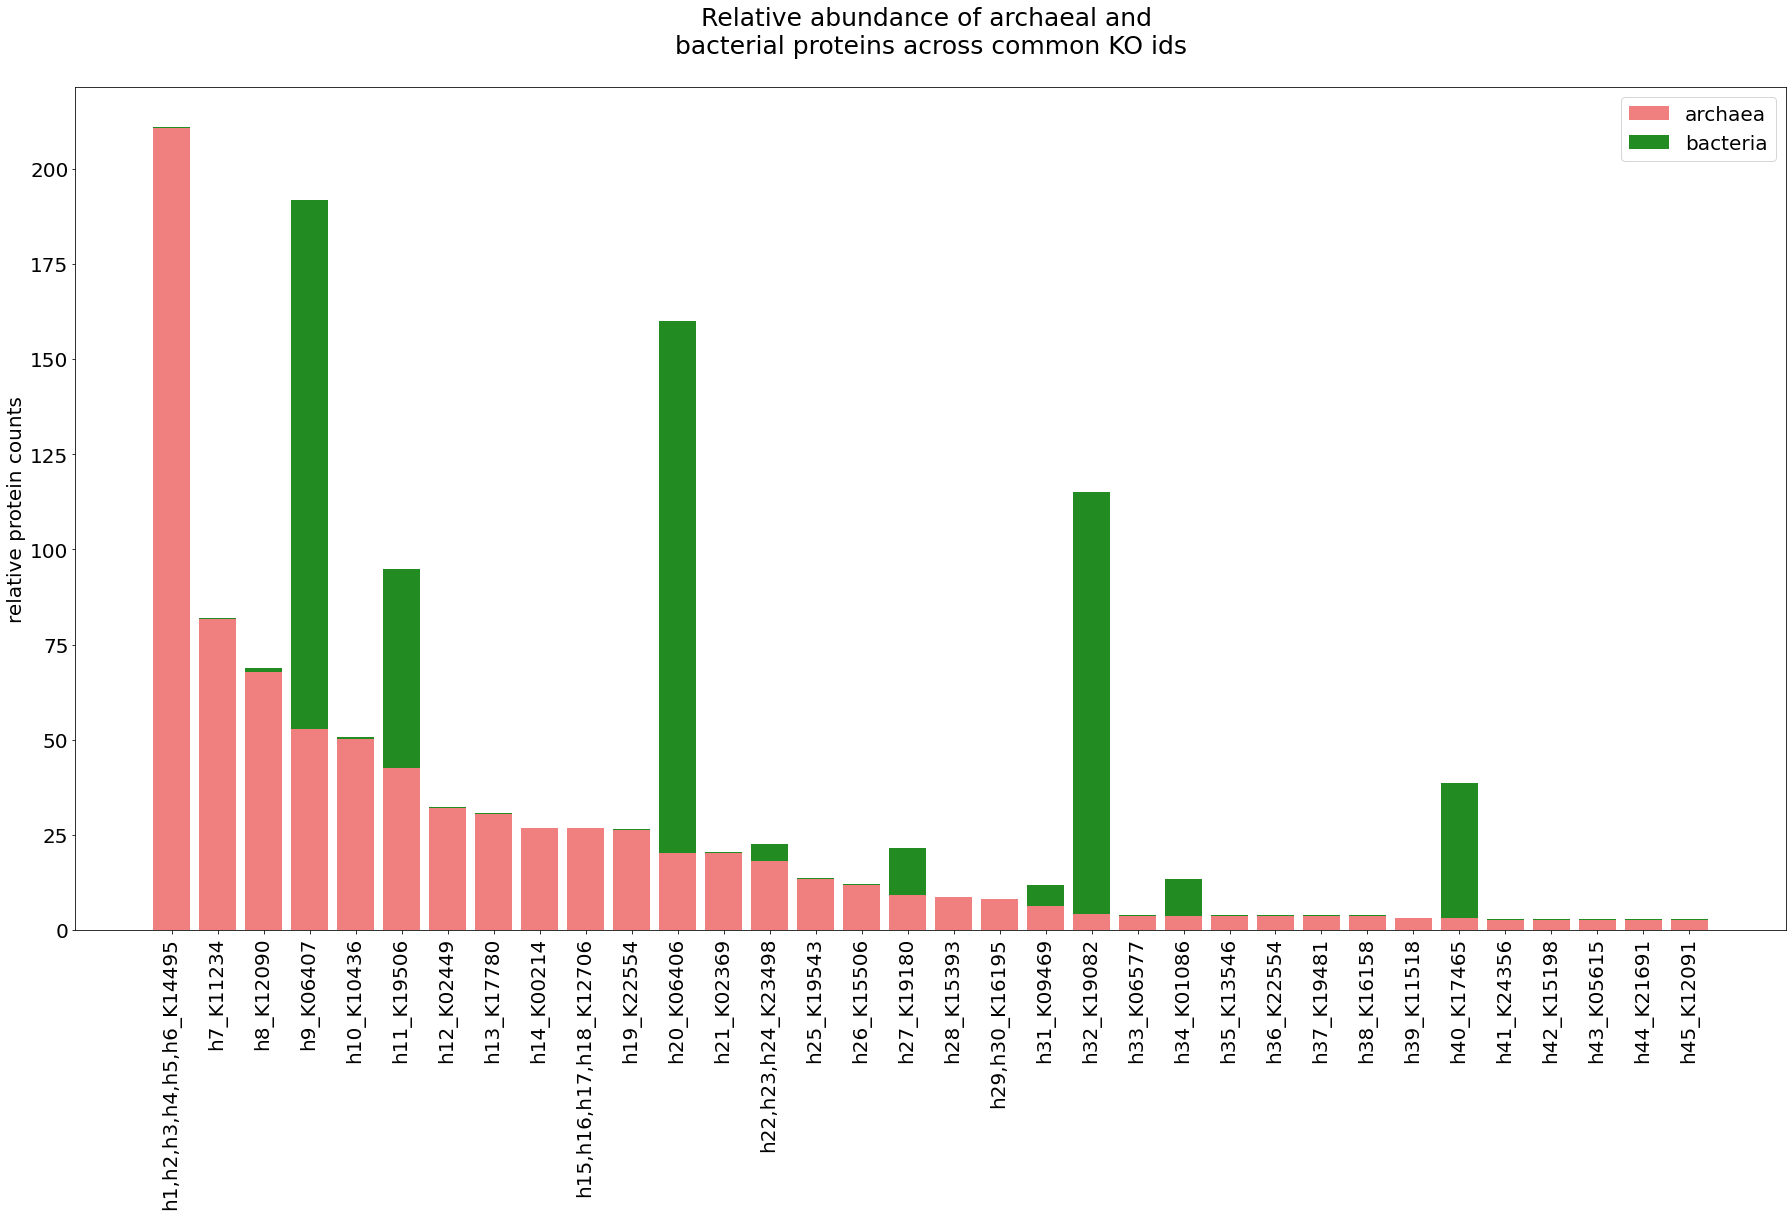

In [47]:
labels = plot_table_curated.cluster_id
width = 0.6
bottoms = plot_table_curated.count_arch

fig, ax = plt.subplots()

fig.set_figwidth(25)
fig.set_figheight(17)

ax.bar(labels, plot_table_curated.count_arch, label='archaea', color = 'lightcoral')
ax.bar(labels, plot_table_curated.count_bac, bottom=bottoms,  label='bacteria', color = 'forestgreen')

ax.set_ylabel('relative protein counts', fontsize = 20)

ax.set_title('Relative abundance of archaeal and \nbacterial proteins across common KO ids\n', fontsize = 25)
ax.legend(fontsize = 20)

plt.xticks(fontsize = 20, rotation = 90)
plt.yticks(fontsize = 20)

plt.tight_layout()

plt.savefig('/work/projects/ecosystem_biology/archaea/coevolution/analysis/intermediate_results/pics/\
relative_abundance_arch_bac_common_kegg.tiff', 
            format='tiff', dpi=300)

plt.show()

#### it's for ABSOLUTE plot (saved to keynote.functions):

In [37]:
# rh_abs = annotated_smash_clusters_remote\
# .groupby(['cluster','id', 'description'], as_index=False)\
# .agg({'protein':'count'})\
# .rename(columns={'protein':'count_PC'})\
# .sort_values(['count_PC'], ascending=False)

# ch_abs = annotated_smash_clusters_close\
# .groupby(['cluster','id', 'description'], as_index=False)\
# .agg({'protein':'count'})\
# .rename(columns={'protein':'count_PC'})\
# .sort_values(['count_PC'], ascending=False)

#### for RELATIVE to bacteria plot:

In [220]:
# ch_rel = annotated_smash_clusters_close\
# .groupby(['id', 'description'], as_index=False)\
# .agg({'protein':'count'})\
# .rename(columns={'protein':'count_PC'})\
# .sort_values(['count_PC'], ascending=False)

# rh_rel = annotated_smash_clusters_remote\
# .groupby(['id', 'description'], as_index=False)\
# .agg({'protein':'count'})\
# .rename(columns={'protein':'count_PC'})\
# .sort_values(['count_PC'], ascending=False)

# plot_arch_rel = pd.concat([rh_rel, ch_rel])\
# .sort_values(['count_PC'], ascending=False)

# plot_arch_rel.reset_index(drop=True, inplace=True)

In [225]:
# # manual curation on of K22554

# plot_arch_rel = plot_arch_rel.sort_values('id').drop_duplicates(['id', 'description'])

# plot_arch_rel.loc[10, 'count_PC'] = 7

need to make a list of bacterial proteins to compare to:

In [226]:
# annotated_smash_clusters_remote_like_bacterial.head()

cluster  count        ids             protein      id  \
0       18      5  b_1878098    3300014559_8_835  K06406   
2       18      5  b_1878098   3300014762_10_441  K06406   
4       18      5  b_1878098   3300014549_6_1932  K06406   
6       18      5  b_1878098  3300014971_22_1106  K06406   
8       18      5  b_1878098   3300029430_20_137  K06406   

                      description  
0  stage V sporulation protein AD  
2  stage V sporulation protein AD  
4  stage V sporulation protein AD  
6  stage V sporulation protein AD  
8  stage V sporulation protein AD

In [265]:
# annotated_smash_clusters_remote_like_bacterial

cluster  count         ids                 protein      id  \
0            18      5   b_1878098        3300014559_8_835  K06406   
2            18      5   b_1878098       3300014762_10_441  K06406   
4            18      5   b_1878098       3300014549_6_1932  K06406   
6            18      5   b_1878098      3300014971_22_1106  K06406   
8            18      5   b_1878098       3300029430_20_137  K06406   
...         ...    ...         ...                     ...     ...   
119980     2594      1  b_13529485   GUT_GENOME109444_30_7  K06407   
119981     2594      1  b_13529485  GUT_GENOME253423_2_162  K06407   
119982     2594      1  b_13529485   GUT_GENOME267240_18_7  K06407   
119983     2594      1  b_13529485   GUT_GENOME279407_14_6  K06407   
119984     2594      1  b_13529485   GUT_GENOME117262_75_2  K06407   

                           description  
0       stage V sporulation protein AD  
2       stage V sporulation protein AD  
4       stage V sporulation protein AD  
6       stage V sporulation protein AD  
8       stage V sporulation protein AD  
...                                ...  
119980  stage V sporulation protein AE  
119981  stage V sporulation protein AE  
119982  stage V sporulation protein AE  
119983  stage V sporulation protein AE  
119984  stage V sporulation protein AE  

[77974 rows x 6 columns]

In [264]:
# annotated_smash_clusters_remote_like_bacterial = candidates\
# .merge(pf_counts[(pf_counts['ratio_b2all']==1)].cluster)\
# .merge(functions_arch_and_bac)\
# .drop_duplicates()

# annotated_smash_clusters_remote_like_bacterial = candidates[candidates.ids.str.startswith('b_')]\
# .merge(functions_arch_and_bac)\
# .drop_duplicates()

doesn't make sense to compare remote_homology arch and bac proteins 

because comparisson will be made through kegg ids which is not relevant here, since we see that different proteins can be called with same kegg ids

so makes sense to only compare to proteins with same kegg and max seq similarity but that's too complicated

maybe only makes sense for protein abundant in archaea and very little in bacteria, let's check

In [228]:
# plot_bac_rel = annotated_smash_clusters_remote_like_bacterial.merge(plot_arch_rel.id)\
# .groupby(['id', 'description'], as_index=False)\
# .agg({'protein':'count'})\
# .rename(columns={'protein':'count_PC'})\
# .sort_values(['count_PC'], ascending=False)

# plot_bac_rel.reset_index(drop=True, inplace=True)

In [229]:
# plot_all = plot_arch_rel.merge(plot_bac_rel, on='id')\
# .rename(columns={
#     'description_x' : 'description_arch',
#     'count_PC_x' : 'count_PC_arch',
#     'description_y' : 'description_bac',
#     'count_PC_y' : 'count_PC_bac'
# })

# plot_all.head()

id                                   description_arch  count_PC_arch  \
0  K00214                               biliverdin reductase             50   
1  K01086  fructose-1,6-bisphosphatase I / sedoheptulose-...              7   
2  K02369    alpha-1,4-N-acetylglucosaminyltransferase EXTL2             38   
3  K02449                         cyclin-dependent kinase 10             60   
4  K05615  solute carrier family 1 (neutral amino acid tr...              5   

                                     description_bac  count_PC_bac  
0                               biliverdin reductase             1  
1  fructose-1,6-bisphosphatase I / sedoheptulose-...           842  
2    alpha-1,4-N-acetylglucosaminyltransferase EXTL2            12  
3                         cyclin-dependent kinase 10            35  
4  solute carrier family 1 (neutral amino acid tr...            19

In [232]:
# plot_all.count_PC_arch = plot_all.count_PC_arch/1874506*1000000
# plot_all.count_PC_bac = plot_all.count_PC_bac/87282994*1000000

In [234]:
# tmp = pd.concat([rh_abs, ch_abs])\
# .sort_values(['count_PC'], ascending=False)[['cluster', 'id']]\
# .rename(columns={'cluster':'arch_cluster'})

#### to know which clusters these are:

In [235]:
# tmp.merge(plot_all, on='id')

arch_cluster      id                                   description_arch  \
0             10  K14495                                 F-box protein GID2   
1              5  K14495                                 F-box protein GID2   
2              8  K14495                                 F-box protein GID2   
3              4  K14495                                 F-box protein GID2   
4              7  K14495                                 F-box protein GID2   
5              3  K14495                                 F-box protein GID2   
6             55  K11234                      mating pheromone alpha-factor   
7              2  K12090                 cag pathogenicity island protein 5   
8           2001  K10436       microtubule-associated protein, RP/EB family   
9             25  K19506  fructoselysine/glucoselysine PTS system EIIA c...   
10            24  K02449                         cyclin-dependent kinase 10   
11            82  K17780  mitochondrial import inner membrane translocas...   
12            35  K06407                     stage V sporulation protein AE   
13            77  K00214                               biliverdin reductase   
14            11  K22554                 acyl-coenzyme A thioesterase THEM5   
15          1972  K22554                 acyl-coenzyme A thioesterase THEM5   
16            35  K06405                     stage V sporulation protein AC   
17            79  K02369    alpha-1,4-N-acetylglucosaminyltransferase EXTL2   
18          1647  K06406                     stage V sporulation protein AD   
19          2012  K19543               aminoglycoside 3'-phosphotransferase   
20            66  K23498                       peptide chain release factor   
21            69  K23498                       peptide chain release factor   
22            67  K23498                       peptide chain release factor   
23            23  K15506             cytochrome P450 family 98 subfamily A8   
24            17  K19180       dTDP-6-deoxy-L-talose 4-dehydrogenase (NAD+)   
25             1  K15393                  beta-cyclopiazonate dehydrogenase   
26            16  K12706               novobiocin biosynthesis protein NovC   
27            12  K12706               novobiocin biosynthesis protein NovC   
28            15  K12706               novobiocin biosynthesis protein NovC   
29            13  K12706               novobiocin biosynthesis protein NovC   
30           366  K09469      2-aminoethylphosphonate-pyruvate transaminase   
31            41  K16195  eukaryotic translation initiation factor 2-alp...   
32            42  K16195  eukaryotic translation initiation factor 2-alp...   
33           147  K19082  two-component system, OmpR family, response re...   
34          2013  K01086  fructose-1,6-bisphosphatase I / sedoheptulose-...   
35            64  K19481                                 matrix Gla protein   
36          1996  K13546                    2-deoxy-scyllo-inosose synthase   
37          2004  K16158       methane monooxygenase component A beta chain   
38          1976  K06577                      Kell blood group glycoprotein   
39          2010  K11518        mitochondrial import receptor subunit TOM40   
40           728  K17465          D-glucosaminate PTS system EIIB component   
41          1995  K15198          transcription factor TFIIIB component B''   
42          1993  K05615  solute carrier family 1 (neutral amino acid tr...   
43          1991  K21691                resuscitation-promoting factor RpfE   
44          1973  K24356                            collagen type XXV alpha   
45          1994  K12091                 cag pathogenicity island protein 6   

    count_PC_arch                                    description_bac  \
0      210.722185                                 F-box protein GID2   
1      210.722185                                 F-box protein GID2   
2      210.722185                                 F-box protein GID2   
3 

### now plot:

remove duplicates for F-box protein for convenience: 

In [189]:
# plot_all_curated = tmp.merge(plot_all, on='id')\
# .drop_duplicates(['id', 'description_arch', 'count_PC_arch', 'description_bac',
#        'count_PC_bac'])

# # how many proteins in cluster 10 (to use the biggest cluster)
# plot_all_curated.loc[0, 'count_PC_arch'] = 343/1874506*1000000

In [190]:
# tmp.merge(plot_all, on='id')

arch_cluster      id                                   description_arch  \
0             10  K14495                                 F-box protein GID2   
1              5  K14495                                 F-box protein GID2   
2              8  K14495                                 F-box protein GID2   
3              4  K14495                                 F-box protein GID2   
4              7  K14495                                 F-box protein GID2   
5              3  K14495                                 F-box protein GID2   
6             55  K11234                      mating pheromone alpha-factor   
7              2  K12090                 cag pathogenicity island protein 5   
8           2001  K10436       microtubule-associated protein, RP/EB family   
9             25  K19506  fructoselysine/glucoselysine PTS system EIIA c...   
10            24  K02449                         cyclin-dependent kinase 10   
11            82  K17780  mitochondrial import inner membrane translocas...   
12            35  K06407                     stage V sporulation protein AE   
13            77  K00214                               biliverdin reductase   
14            11  K22554                 acyl-coenzyme A thioesterase THEM5   
15            11  K22554                 acyl-coenzyme A thioesterase THEM5   
16          1972  K22554                 acyl-coenzyme A thioesterase THEM5   
17          1972  K22554                 acyl-coenzyme A thioesterase THEM5   
18            35  K06405                     stage V sporulation protein AC   
19            79  K02369    alpha-1,4-N-acetylglucosaminyltransferase EXTL2   
20          1647  K06406                     stage V sporulation protein AD   
21          2012  K19543               aminoglycoside 3'-phosphotransferase   
22            66  K23498                       peptide chain release factor   
23            69  K23498                       peptide chain release factor   
24            67  K23498                       peptide chain release factor   
25            23  K15506             cytochrome P450 family 98 subfamily A8   
26            17  K19180       dTDP-6-deoxy-L-talose 4-dehydrogenase (NAD+)   
27             1  K15393                  beta-cyclopiazonate dehydrogenase   
28            16  K12706               novobiocin biosynthesis protein NovC   
29            12  K12706               novobiocin biosynthesis protein NovC   
30            15  K12706               novobiocin biosynthesis protein NovC   
31            13  K12706               novobiocin biosynthesis protein NovC   
32           366  K09469      2-aminoethylphosphonate-pyruvate transaminase   
33            41  K16195  eukaryotic translation initiation factor 2-alp...   
34            42  K16195  eukaryotic translation initiation factor 2-alp...   
35           147  K19082  two-component system, OmpR family, response re...   
36          2013  K01086  fructose-1,6-bisphosphatase I / sedoheptulose-...   
37            64  K19481                                 matrix Gla protein   
38          1996  K13546                    2-deoxy-scyllo-inosose synthase   
39          2004  K16158       methane monooxygenase component A beta chain   
40          1976  K06577                      Kell blood group glycoprotein   
41          2010  K11518        mitochondrial import receptor subunit TOM40   
42           728  K17465          D-glucosaminate PTS system EIIB component   
43          1995  K15198          transcription factor TFIIIB component B''   
44          1993  K05615  solute carrier family 1 (neutral amino acid tr...   
45          1991  K21691                resuscitation-promoting factor RpfE   
46          1973  K24356                            collagen type XXV alpha   
47          1994  K12091                 cag pathogenicity island protein 6   

    count_PC_arch                                    description_bac  \
0      210.722185                                 F-box prot

In [191]:
# plot_all_curated.head()

arch_cluster      id                                   description_arch  \
0            10  K14495                                 F-box protein GID2   
6            55  K11234                      mating pheromone alpha-factor   
7             2  K12090                 cag pathogenicity island protein 5   
8          2001  K10436       microtubule-associated protein, RP/EB family   
9            25  K19506  fructoselysine/glucoselysine PTS system EIIA c...   

   count_PC_arch                                    description_bac  \
0     182.981543                                 F-box protein GID2   
6      81.621505                      mating pheromone alpha-factor   
7      67.751184                 cag pathogenicity island protein 5   
8      50.146545       microtubule-associated protein, RP/EB family   
9      42.677911  fructoselysine/glucoselysine PTS system EIIA c...   

   count_PC_bac  
0      0.229140  
6      0.332253  
7      1.065500  
8      0.595763  
9     52.209483

In [192]:
# plot_all_curated['arch_cluster_str'] = 'cluster_' + plot_all_curated.arch_cluster.astype(str)
# plot_all_curated = plot_all_curated[['arch_cluster', 'arch_cluster_str', 'id', 'description_arch', 'count_PC_arch',
#        'description_bac', 'count_PC_bac']]

In [193]:
# plot_all_curated['arch_cluster_kegg'] = plot_all_curated.arch_cluster.astype(str) + '_' + \
# + plot_all_curated.id.astype(str)
# plot_all_curated = plot_all_curated[['arch_cluster_kegg', 'description_arch', 'count_PC_arch',
#        'description_bac', 'count_PC_bac']]

In [194]:
# plot_all_curated.head()

arch_cluster_kegg                                   description_arch  \
0         10_K14495                                 F-box protein GID2   
6         55_K11234                      mating pheromone alpha-factor   
7          2_K12090                 cag pathogenicity island protein 5   
8       2001_K10436       microtubule-associated protein, RP/EB family   
9         25_K19506  fructoselysine/glucoselysine PTS system EIIA c...   

   count_PC_arch                                    description_bac  \
0     182.981543                                 F-box protein GID2   
6      81.621505                      mating pheromone alpha-factor   
7      67.751184                 cag pathogenicity island protein 5   
8      50.146545       microtubule-associated protein, RP/EB family   
9      42.677911  fructoselysine/glucoselysine PTS system EIIA c...   

   count_PC_bac  
0      0.229140  
6      0.332253  
7      1.065500  
8      0.595763  
9     52.209483

In [195]:
# plot_all_curated = plot_all_curated[plot_all_curated.description_arch != 'stage V sporulation protein AC']

In [196]:
# plot_all_curated

arch_cluster_kegg                                   description_arch  \
0          10_K14495                                 F-box protein GID2   
6          55_K11234                      mating pheromone alpha-factor   
7           2_K12090                 cag pathogenicity island protein 5   
8        2001_K10436       microtubule-associated protein, RP/EB family   
9          25_K19506  fructoselysine/glucoselysine PTS system EIIA c...   
10         24_K02449                         cyclin-dependent kinase 10   
11         82_K17780  mitochondrial import inner membrane translocas...   
12         35_K06407                     stage V sporulation protein AE   
13         77_K00214                               biliverdin reductase   
14         11_K22554                 acyl-coenzyme A thioesterase THEM5   
15         11_K22554                 acyl-coenzyme A thioesterase THEM5   
19         79_K02369    alpha-1,4-N-acetylglucosaminyltransferase EXTL2   
20       1647_K06406                     stage V sporulation protein AD   
21       2012_K19543               aminoglycoside 3'-phosphotransferase   
22         66_K23498                       peptide chain release factor   
25         23_K15506             cytochrome P450 family 98 subfamily A8   
26         17_K19180       dTDP-6-deoxy-L-talose 4-dehydrogenase (NAD+)   
27          1_K15393                  beta-cyclopiazonate dehydrogenase   
28         16_K12706               novobiocin biosynthesis protein NovC   
32        366_K09469      2-aminoethylphosphonate-pyruvate transaminase   
33         41_K16195  eukaryotic translation initiation factor 2-alp...   
35        147_K19082  two-component system, OmpR family, response re...   
36       2013_K01086  fructose-1,6-bisphosphatase I / sedoheptulose-...   
37         64_K19481                                 matrix Gla protein   
38       1996_K13546                    2-deoxy-scyllo-inosose synthase   
39       2004_K16158       methane monooxygenase component A beta chain   
40       1976_K06577                      Kell blood group glycoprotein   
41       2010_K11518        mitochondrial import receptor subunit TOM40   
42        728_K17465          D-glucosaminate PTS system EIIB component   
43       1995_K15198          transcription factor TFIIIB component B''   
44       1993_K05615  solute carrier family 1 (neutral amino acid tr...   
45       1991_K21691                resuscitation-promoting factor RpfE   
46       1973_K24356                            collagen type XXV alpha   
47       1994_K12091                 cag pathogenicity island protein 6   

    count_PC_arch                                    description_bac  \
0      182.981543                                 F-box protein GID2   
6       81.621505                      mating pheromone alpha-factor   
7       67.751184                 cag pathogenicity island protein 5   
8       50.146545       microtubule-associated protein, RP/EB family   
9       42.677911  fructoselysine/glucoselysine PTS system EIIA c...   
10      32.008433                         cyclin-dependent kinase 10   
11      30.408011  mitochondrial import inner membrane translocas...   
12      28.274116                     stage V sporulation protein AE   
13      26.673694                               biliverdin reductase   
14      26.140220                 acyl-coenzyme A thioesterase THEM5   
15       3.734317                 acyl-coenzyme A thioesterase THEM5   
19      20.272008    alpha-1,4-N-acetylglucosaminyltransferase EXTL2   
20      20.272008                     stage V sporulation protein AD   
21      13.336847               aminoglycoside 3'-phosphotransferase   
22      18.138112                       peptide chain release factor   
25      11.736425             cytochrome P450 family 98 subfamily A8   
26       9.069056       dTDP-6-deoxy-L-talose 4-dehydrogenase (NAD+)   
27       8.535582                  beta-cyclopiazonate dehydrogenase   
28      2

<BarContainer object of 34 artists>

<BarContainer object of 34 artists>

Text(0, 0.5, 'relative protein counts')

Text(0.5, 1.0, 'Relative abundance of archaeal and \nbacterial proteins across common KO ids\n')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 <a list of 33 Text major ticklabel objects>)

(array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 <a list of 9 Text major ticklabel objects>)

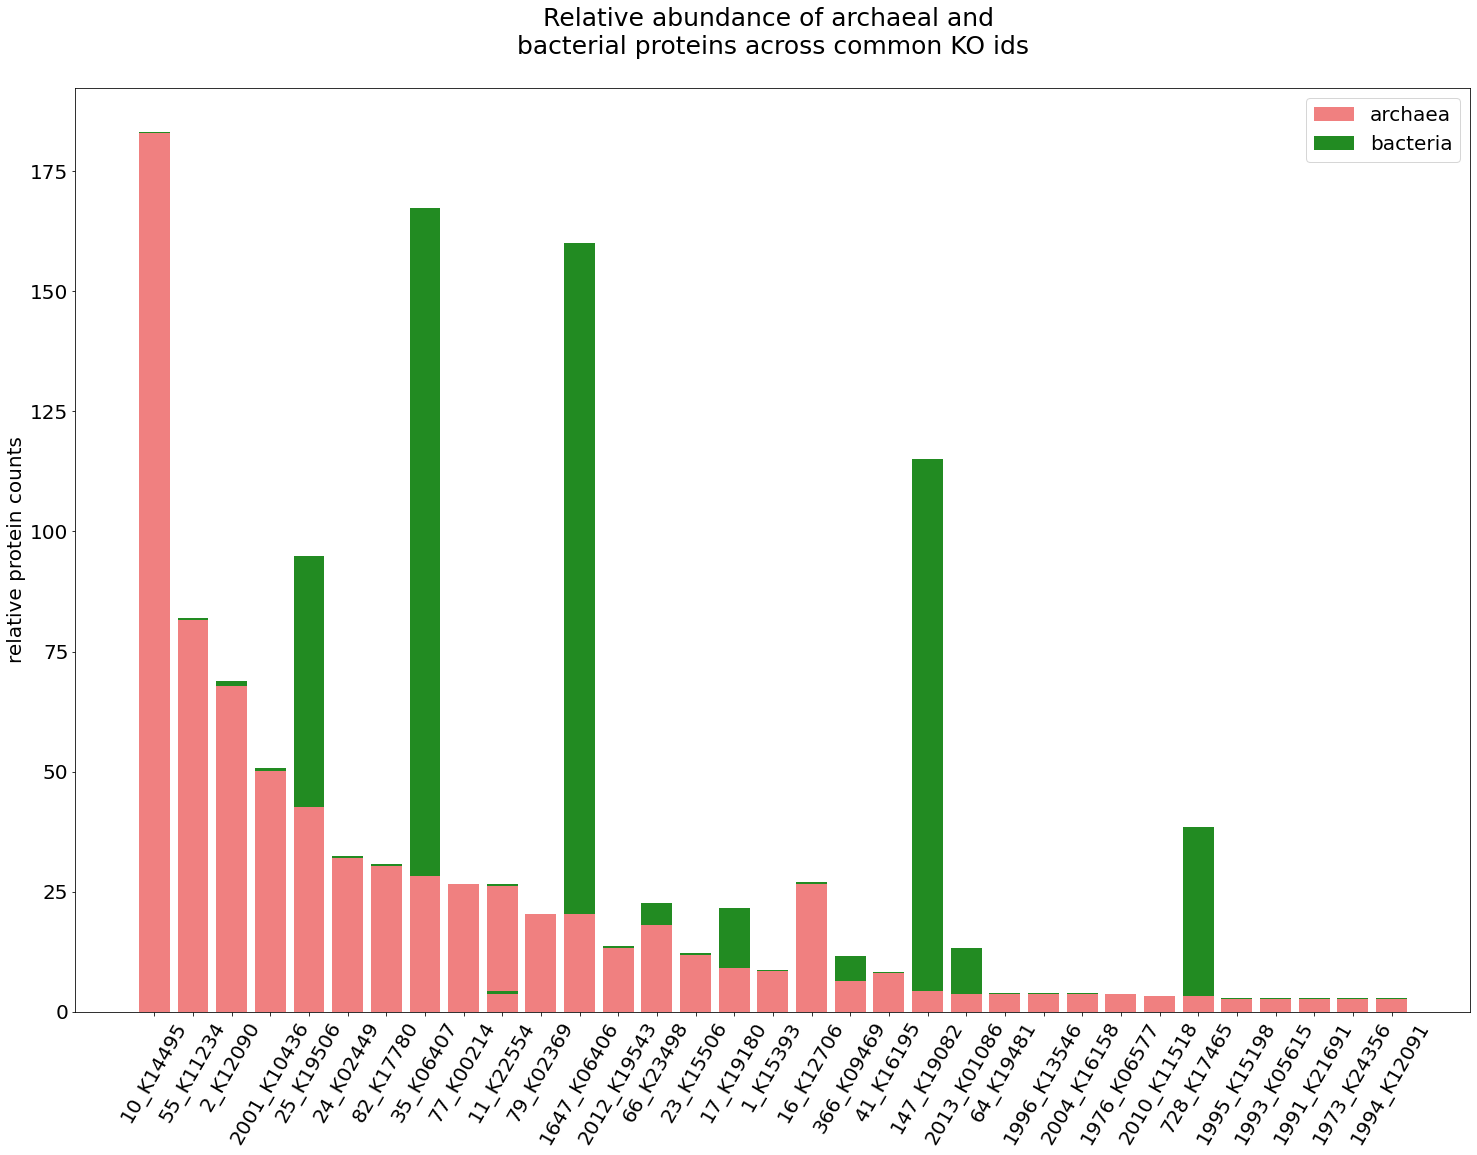

In [197]:
# labels = plot_all_curated.arch_cluster_kegg
# width = 0.6
# bottoms = plot_all_curated.count_PC_arch

# fig, ax = plt.subplots()

# fig.set_figwidth(25)
# fig.set_figheight(17)

# ax.bar(labels, plot_all_curated.count_PC_arch, label='archaea', color = 'lightcoral')
# ax.bar(labels, plot_all_curated.count_PC_bac, bottom=bottoms,  label='bacteria', color = 'forestgreen')

# ax.set_ylabel('relative protein counts', fontsize = 20)

# ax.set_title('Relative abundance of archaeal and \nbacterial proteins across common KO ids\n', fontsize = 25)
# ax.legend(fontsize = 20)

# plt.xticks(fontsize = 20, rotation = 60)
# plt.yticks(fontsize = 20)

# plt.savefig('/work/projects/ecosystem_biology/archaea/coevolution/analysis/intermediate_results/pics/\
# relative_abundance_arch_bac_common_kegg.png', 
#             format='png', dpi=75)

# plt.show()